In [1]:
import numpy as np
import matplotlib.pyplot as plt


(37500, 32, 32, 3) (37500, 10) (12500, 32, 32, 3) (12500, 10) (10000, 32, 32, 3) (10000, 10)


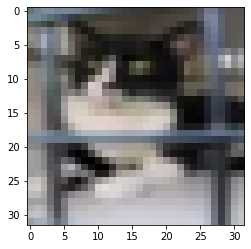

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] cat


In [2]:
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.utils import to_categorical
(train_images, train_labels), (x_test, y_test) = cifar10.load_data()


train_images = train_images.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
train_labels = to_categorical(train_labels, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images,train_labels,random_state=123)

print(x_train.shape,
      y_train.shape,
      x_val.shape,
      y_val.shape,
      x_test.shape,
      y_test.shape)

def labeling_vec(t):
    label_list = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    ll = np.arange(10)
    l = np.dot(t,ll)
    return label_list[int(l)]

k = 9
plt.imshow(x_train[k])
plt.show()
print(y_train[k],labeling_vec(y_train[k]))

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import models
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input

# 使うGPU番号を指定(私の場合は9番を使用)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# tensorflowは普通に使用すると、GPUメモリを取れるだけとってしまうため、最小限だけ使うように設定する。（命苫メソッド）
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
from keras.callbacks import LearningRateScheduler

EPOCHS = 150
# 学習率
def step_decay(epoch):
    x = 0.0001
    warmup = 5
    if epoch < warmup:
        x *= (epoch+1)/warmup
    else:
        x *= (1 + np.cos(np.pi*(epoch+1-warmup)/EPOCHS))/2
    return x




def basic_conv_block(input, chs, sh, reps): ##sh畳み込み大きさ, reps回数
    x = input
    for i in range(reps):
        x = layers.Conv2D(chs,(sh,sh),padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
    return x

def create_cnn(SHAPE,channel):
    input = Input(shape=(SHAPE,SHAPE,channel))
    x = basic_conv_block(input, 64, 5, 1)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 128, 3, 3)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 256, 3, 3)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(10)(x)
    x = layers.Activation('softmax')(x)

    model = Model(input, x)
    return model



from tensorflow.keras.callbacks import History, Callback
from keras.objectives import categorical_crossentropy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from scipy.stats import mode
import os, pickle
import tensorflow.keras.backend as K

# 確率の平均を取るアンサンブル（ソフトアンサンブル）
def ensembling_soft(models, X):
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = model.predict(X)
        else:
            preds_sum += model.predict(X)
    probs = preds_sum / len(models)
    return to_categorical(np.argmax(probs, axis=1), num_classes=10)

# 多数決のアンサンブル（ハードアンサンブル）
def ensembling_hard(models, X):
    pred_labels = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        pred_labels[:, i] = np.argmax(model.predict(X), axis=1)
    return to_categorical(mode(pred_labels, axis=1)[0], num_classes=10)

class Checkpoint(Callback):
    def __init__(self, model, filepath):
        self.model = model
        self.filepath = filepath
        self.best_val_acc = 0.0

    def on_epoch_end(self, epoch, logs):
        if self.best_val_acc < logs["val_acc"]:
            self.model.save_weights(self.filepath, save_format="h5")
            self.best_val_acc = logs["val_acc"]
            print("Weights saved.", self.best_val_acc)

In [8]:
vers = 4

def load_allmodels(vers,num,SHAPE,channel):
    allmodels = []
    for i in range(num):
        train_model = create_cnn(SHAPE,channel)
        train_model.load_weights(f"weights{vers}_{i}.hdf5")
        for layer in train_model.layers:
            layer.trainable = False
        allmodels.append(train_model)
    return allmodels

def ensembling_both(models, X, y):
    #soft ensemble
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = model.predict(X)
        else:
            preds_sum += model.predict(X)
    probs = preds_sum / len(models)
    soft_ens_y_pred = to_categorical(np.argmax(probs, axis=1), num_classes=10)
    soft_ens_acc = accuracy_score(y, soft_ens_y_pred)
    #hard ensemble
    pred_labels = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        pred_labels[:, i] = np.argmax(model.predict(X), axis=1)
    hard_ens_y_pred = to_categorical(mode(pred_labels, axis=1)[0], num_classes=10)
    hard_ens_acc = accuracy_score(y, hard_ens_y_pred)
    return soft_ens_acc, hard_ens_acc

SHAPE=32
channel=3
allmodels = load_allmodels(vers,4,SHAPE,channel)


for i in range(4):
    log_data = pd.read_csv('cf10_trlog_{}_{}'.format(vers,i), sep=',', engine='python')
    print('version:',vers,i,'best val score',np.max(log_data.val_acc))
#print('version:',vers,'soft ensemble val accuracy:',ensemble_tests_acc)
#print('version:',vers,'hard ensemble val accuracy:',ensemble_test_acc_h)

print(ensembling_both(allmodels,x_val,y_val))

version: 4 0 best val score 0.7360800000000001
version: 4 1 best val score 0.74088
version: 4 2 best val score 0.7392
version: 4 3 best val score 0.74592
(0.79008, 0.78128)


In [9]:
allmodels[0].summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_32 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 128)       512 

In [10]:
#functional APIで作成したモデルの最終レイヤーを取り除く

def funcmodelpop(model):
    seq_model = Sequential()
    for layer in model.layers[:-1]: # just exclude last layer from copying
        seq_model.add(layer)
    for layer in seq_model.layers:
        layer.trainable = False
    return seq_model

teachers = []
for i in range(len(allmodels)):
    teachers.append(funcmodelpop(allmodels[i]))
teachers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_32 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
activation_33 (Activation)   (None, 16, 16, 128)       0

In [63]:
def create_cnn_st(SHAPE,channel):
    input = Input(shape=(SHAPE,SHAPE,channel))
    x = basic_conv_block(input, 64, 5, 1)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 128, 3, 2)  ##repsを3から2に
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 256, 3, 2)  ##repsを3から2に
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(10)(x)

    model = Model(input, x)
    return model


vers = 4

student = create_cnn_st(SHAPE,channel)
student.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_96 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_118 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d_32 (Averag (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_97 (Batc (None, 16, 16, 128)       512

In [64]:
#合体させてく
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate

model_input = Input(shape=(32,32,3))

student_logid = student(model_input)
teacher_logid_1 = teachers[0](model_input)
teacher_logid_2 = teachers[1](model_input)
teacher_logid_3 = teachers[2](model_input)
teacher_logid_4 = teachers[3](model_input)
#teacher_logid_5 = teachers[4](model_input)

student_softmax = layers.Activation('softmax',name="student_softmax")(student_logid)

#teacher_ensemble = Concatenate(axis=-1)([teacher_logid_1, teacher_logid_2, teacher_logid_3, teacher_logid_4, teacher_logid_5])
#teacher_logids = layers.Dense(10)(teacher_ensemble)

logids = Concatenate(axis=-1)([student_logid,
                               teacher_logid_1,
                               teacher_logid_2,
                               teacher_logid_3,
                               teacher_logid_4,
                               #teacher_logid_5
                              ])

model = Model(inputs=model_input, outputs=[student_softmax, logids])
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_32 (Model)                (None, 10)           1117450     input_35[0][0]                   
__________________________________________________________________________________________________
sequential (Sequential)         (None, 10)           1856650     input_35[0][0]                   
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           1856650     input_35[0][0]                   
___________________________________________________________________________________________

In [65]:
#trainable paraがstudentのparameter、nonがteacherのparameter
import tensorflow.keras.backend as K
import tensorflow as tf

temperature = 20.

def distillation_loss(y_true, y_pred):
    student_logid, teacher_logid_1, teacher_logid_2, teacher_logid_3, teacher_logid_4 = tf.split(y_pred, 5, axis=-1) #, teacher_logid_5
  
    student_soft = K.softmax(student_logid/temperature)
    teacher_soft_1 = K.softmax(teacher_logid_1/temperature)
    #teacher_soft_2 = K.softmax(teacher_logid_2/temperature)
    #teacher_soft_3 = K.softmax(teacher_logid_3/temperature)
    #teacher_soft_4 = K.softmax(teacher_logid_4/temperature)
    #teacher_soft_5 = K.softmax(teacher_logid_5/temperature)
    
    preds_sum = teacher_soft_1
    #preds_sum += teacher_soft_2
    #preds_sum += teacher_soft_3
    #preds_sum += teacher_soft_4
    #preds_sum += teacher_soft_5
    teacher_ensemble = preds_sum / 1

    #teacher_ensemble = to_categorical(tf.math.argmax(probs, axis=1), num_classes=10)

    
    return K.categorical_crossentropy(teacher_ensemble, student_soft)


In [66]:
from tensorflow.keras import optimizers

lambda_const = 0.9
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss = ["categorical_crossentropy",distillation_loss], loss_weights=[1-lambda_const, lambda_const * temperature**2], optimizer = adam)


#student learning with teacher modelsff

EPOCHS = 50
csv_logger = CSVLogger('distill_trlog_student_{}'.format(vers), separator=',', append=False)

early_stopping = EarlyStopping(monitor="val_acc", patience=8)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
learning_rate = LearningRateScheduler(step_decay,verbose=1)
#cp = Checkpoint_student(model, student, f"weights_student{vers}.hdf5")

history = model.fit(x=x_train,
                    y=[y_train,y_train],
                    epochs=EPOCHS,
                    #validation_data=(x_val,y_val),
                    #validation_steps=50,
                    #use_multiprocessing=True,
                    #workers=4,
                    callbacks=[#cp,
                               #early_stopping,
                               csv_logger]
                               #learning_rate]
                    )

Train on 37500 samples
Epoch 1/50
37500/37500 [==============================] - 23s 617us/sample - loss: 826.7808 - student_softmax_loss: 1.5607 - concatenate_8_loss: 2.2962
Epoch 2/50
37500/37500 [==============================] - 21s 552us/sample - loss: 825.5352 - student_softmax_loss: 1.0349 - concatenate_8_loss: 2.2929
Epoch 3/50
37500/37500 [==============================] - 21s 551us/sample - loss: 825.1411 - student_softmax_loss: 0.8132 - concatenate_8_loss: 2.2918
Epoch 4/50
37500/37500 [==============================] - 21s 551us/sample - loss: 824.9469 - student_softmax_loss: 0.6906 - concatenate_8_loss: 2.2913
Epoch 5/50
37500/37500 [==============================] - 21s 551us/sample - loss: 824.8182 - student_softmax_loss: 0.6041 - concatenate_8_loss: 2.2910
Epoch 6/50
37500/37500 [==============================] - 21s 551us/sample - loss: 824.7122 - student_softmax_loss: 0.5317 - concatenate_8_loss: 2.2907
Epoch 7/50
37500/37500 [==============================] - 21s 554

In [67]:
#1model
full_input = Input(shape=(32,32,3))
full_logid = student(full_input)
full_output = layers.Activation('softmax')(full_logid)

full_student = Model(inputs=full_input, outputs=full_output)

full_student.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
#full_student.summary()

print(full_student.evaluate(x_val, y_val))

for i in range(1):
    log_data = pd.read_csv('cf10_trlog_{}_{}'.format(vers,i), sep=',', engine='python')
    print('version:',vers,i,'best val score',np.max(log_data.val_acc))
#print('version:',vers,'soft ensemble val accuracy:',ensemble_tests_acc)
#print('version:',vers,'hard ensemble val accuracy:',ensemble_test_acc_h)

print(ensembling_both(allmodels[:1],x_val,y_val))

12500/12500 [==============================] - 2s 143us/sample - loss: 0.6445 - accuracy: 0.7918
[0.6445278978729249, 0.79184]
version: 4 0 best val score 0.7360800000000001
(0.73608, 0.73608)


In [62]:
#2model
full_input = Input(shape=(32,32,3))
full_logid = student(full_input)
full_output = layers.Activation('softmax')(full_logid)

full_student = Model(inputs=full_input, outputs=full_output)

full_student.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
#full_student.summary()

print(full_student.evaluate(x_val, y_val))

for i in range(2):
    log_data = pd.read_csv('cf10_trlog_{}_{}'.format(vers,i), sep=',', engine='python')
    print('version:',vers,i,'best val score',np.max(log_data.val_acc))
#print('version:',vers,'soft ensemble val accuracy:',ensemble_tests_acc)
#print('version:',vers,'hard ensemble val accuracy:',ensemble_test_acc_h)

print(ensembling_both(allmodels[:1],x_val,y_val))

12500/12500 [==============================] - 2s 153us/sample - loss: 0.5760 - accuracy: 0.8080
[0.5759807893753052, 0.808]
version: 4 0 best val score 0.7360800000000001
version: 4 1 best val score 0.74088
(0.73608, 0.73608)


In [55]:
#3model
full_input = Input(shape=(32,32,3))
full_logid = student(full_input)
full_output = layers.Activation('softmax')(full_logid)

full_student = Model(inputs=full_input, outputs=full_output)

full_student.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
full_student.summary()

full_student.evaluate(x_val, y_val)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_25 (Model)             (None, 10)                1117450   
_________________________________________________________________
activation_110 (Activation)  (None, 10)                0         
Total params: 1,117,450
Trainable params: 1,115,786
Non-trainable params: 1,664
_________________________________________________________________
12500/12500 [==============================] - 2s 148us/sample - loss: 0.5574 - accuracy: 0.8140


[0.5574472402954102, 0.814]

In [56]:
for i in range(3):
    log_data = pd.read_csv('cf10_trlog_{}_{}'.format(vers,i), sep=',', engine='python')
    print('version:',vers,i,'best val score',np.max(log_data.val_acc))
#print('version:',vers,'soft ensemble val accuracy:',ensemble_tests_acc)
#print('version:',vers,'hard ensemble val accuracy:',ensemble_test_acc_h)

print(ensembling_both(allmodels[:2],x_val,y_val))

version: 4 0 best val score 0.7360800000000001
version: 4 1 best val score 0.74088
version: 4 2 best val score 0.7392
(0.76688, 0.73952)


In [41]:
#4model
full_input = Input(shape=(32,32,3))
full_logid = student(full_input)
full_output = layers.Activation('softmax')(full_logid)

full_student = Model(inputs=full_input, outputs=full_output)

full_student.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
full_student.summary()

full_student.evaluate(x_val, y_val)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_18 (Model)             (None, 10)                1117450   
_________________________________________________________________
activation_96 (Activation)   (None, 10)                0         
Total params: 1,117,450
Trainable params: 1,115,786
Non-trainable params: 1,664
_________________________________________________________________
12500/12500 [==============================] - 2s 148us/sample - loss: 0.5505 - accuracy: 0.8194


[0.5505422951507568, 0.81936]

In [43]:
for i in range(4):
    log_data = pd.read_csv('cf10_trlog_{}_{}'.format(vers,i), sep=',', engine='python')
    print('version:',vers,i,'best val score',np.max(log_data.val_acc))
#print('version:',vers,'soft ensemble val accuracy:',ensemble_tests_acc)
#print('version:',vers,'hard ensemble val accuracy:',ensemble_test_acc_h)

print(ensembling_both(allmodels[:3],x_val,y_val))

version: 4 0 best val score 0.7360800000000001
version: 4 1 best val score 0.74088
version: 4 2 best val score 0.7392
version: 4 3 best val score 0.74592
(0.77984, 0.77152)
